# **Proyecto Fundamentos de Aprendizaje por Refuerzo**
## Integrantes:
- Alberto Lyons
- Fernando Vega
- Nicolás Gonzalez

## **Se recomienda crear un env de python en la versión 3.10**

## Instalación de librerias para el entorno

In [ ]:
!pip install -r requirements.txt

## Importación de librerias

In [3]:
import gymnasium as gym
import numpy as np
import mujoco
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import random
from IPython.display import Image
import imageio
import matplotlib.pyplot as plt

## Entorno

### **Pusher**
Obtenido en la siguiente página: https://gymnasium.farama.org/environments/mujoco/pusher/

### **Descripción**

<img src="https://gymnasium.farama.org/_images/pusher.gif" alt="Pusher" width="300"/>

"Pusher" es un brazo robótico articulado que se asemeja al brazo humano. El objetivo es mover un cilindro objetivo (denominado objeto) hasta una posición de destino utilizando el extremo del brazo robótico (denominado punta del dedo o efector final). El robot está compuesto por articulaciones en el hombro, codo, antebrazo y muñeca.

## Espacio de acción

<img src="https://gymnasium.farama.org/_images/pusher.png" alt="Pusher actions" width="400"/>

|Número| Observación | mín.| máx. |
|-----------|-----------|-----------|-----------|
|0| Rotación del giro del hombro [N/m] | -2.0 | 2.0 |
|1| Rotación de la articulación que eleva el hombro [N/m] | -2.0 | 2.0 |
|2| Rotación de la articulación que rota el hombro [N/m] | -2.0 | 2.0 |
|3| Rotación de la articulación tipo bisagra que flexiona el codo [N/m] | -2.0 | 2.0 |
|4| Rotación de la bisagra que gira el antebrazo [N/m] | -2.0 | 2.0 |
|5| Rotación de la flexión de la muñeca [N/m] | -2.0 | 2.0 |
|6| Rotación del giro de la muñeca [N/m] | -2.0 | 2.0 |

Todas este conjunto funciona con Newton/metro, que sería el torque $\tau$ aplicado

## Conjunto de observaciones

|Número| Observación | mín.| máx. |
|-----------|-----------|-----------|-----------|
|0| Rotación del hombro en panóramica [rad] | -inf | inf |
|1| Rotación de la articulación de elevación del hombro [rad] | -inf | inf |
|2| Rotación de la articulación de giro del hombro [rad] | -inf | inf |
|3| Rotación de la articulación de bisagra que flexiona el codo [rad] | -inf | inf |
|4| Rotación de la bisagra que gira el antebrazo [rad] | -inf | inf |
|5| Rotación de la flexión de la muñeca [rad] | -inf | inf |
|6| Rotación del giro de la muñeca [rad] | -inf | inf |
|7| Velocidad de rotación del hombro en panóramica [rad/s] | -inf | inf |
|8| Velocidad de rotación de la articulación de elevación del hombro [rad/s] | -inf | inf |
|9| Velocidad de rotación de la articulación de giro del hombro [rad/s] | -inf | inf |
|10| Velocidad de rotación de la articulación de bisagra que flexiona el codo [rad/s] | -inf | inf |
|11| Velocidad de rotación de la bisagra que gira el antebrazo [rad/s] | -inf | inf |
|12| Velocidad de rotación de la flexión de la muñeca [rad/s] | -inf | inf |
|13| Velocidad de rotación del giro de la muñeca [rad/s] | -inf | inf |
|14| Coordenada x de la punta del empujador [m] | -inf | inf |
|15| Coordenada y de la punta del empujador [m] | -inf | inf |
|16| Coordenada z de la punta del empujador [m] | -inf | inf |
|17| Coordenada x del objeto a mover [m] | -inf | inf |
|18| Coordenada y del objeto a mover [m] | -inf | inf |
|19| Coordenada z del objeto a mover [m] | -inf | inf |
|20| Coordenada x de la posición objetivo del objeto [m] | -inf | inf |
|21| Coordenada y de la posición objetivo del objeto [m] | -inf | inf |
|22| Coordenada z de la posición objetivo del objeto [m] | -inf | inf |

## Observación del entorno
- Definición de número de estados
- Definición de número de acciones

In [19]:
env = gym.make("Pusher-v5")
num_states = env.observation_space.shape[0] # Número de estados
num_actions = env.action_space.shape[0] # Número de acciones
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print(f"Numero de espacio de estados: {num_states} | Numero de espacio de acciones: {num_actions}")
print(f"Intervalo de valor de la acción: [{lower_bound}, {upper_bound}]")

Numero de espacio de estados: 23 | Numero de espacio de acciones: 7
Intervalo de valor de la acción: [-2.0, 2.0]


## Funcionamiento del entorno
Se observa como funciona el entorno de "Pusher" donde no se le aplica ningun agente con el fin de ver las características del entorno

Episode: 1  Total Reward: 0  Steps: 100


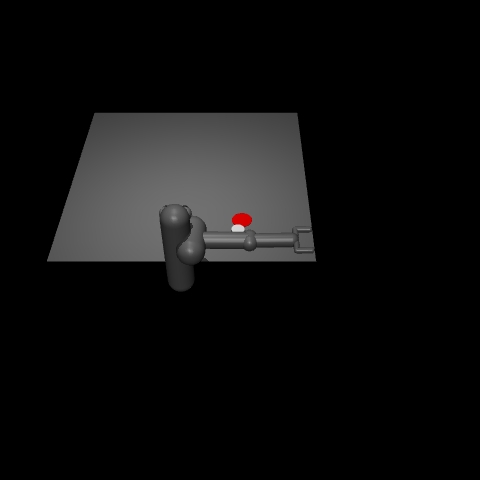

In [20]:
env = gym.make('Pusher-v5',render_mode="rgb_array")
state, _ = env.reset()
done = False
total_reward = 0
steps = 0
frames = []
for i in range(100):
    action = env.action_space.sample()
    next_state, reward, terminal, truncated, _ = env.step(action)
    done = terminal or truncated
    frame = env.render()
    frames.append(frame)
    state = next_state
    steps += 1
print("Episode:",1," Total Reward:",total_reward," Steps:",steps)
env.close()
imageio.mimsave('pusher_env.gif', frames, fps=30)
Image(filename='pusher_env.gif')

## Desarrollo del algoritmo a implementar
### **Se implementará el siguiente algoritmo: Deep Deterministic Policy Gradient**

### Clase para poder personalizar la recompensa

In [4]:
class CustomPusherWrapper(gym.Wrapper):    
    def __init__(self, env):
        super().__init__(env)
        self.previous_distance = None
        self.previous_fingertip_distance = None
        self.target_position = None
        self.object_initial_pos = None
        self.max_fingertip_distance = 0.15 
        self.learning_stage = 0  
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        try:
            if len(obs) >= 23:
                self.target_position = obs[20:23]
                self.object_initial_pos = obs[17:20]
                
                self.previous_distance = np.linalg.norm(obs[17:20] - self.target_position)
                
                fingertip_pos = self._get_fingertip_position(obs)
                object_pos = obs[17:20]
                self.previous_fingertip_distance = np.linalg.norm(fingertip_pos - object_pos)
                
            else:
                self.target_position = np.array([0.0, 0.0, 0.0])
                self.object_initial_pos = np.array([0.0, 0.0, 0.0])
                self.previous_distance = 1.0
                self.previous_fingertip_distance = 0.05
        except Exception as e:
            print(f"Error in reset: {e}")
            self.target_position = np.array([0.0, 0.0, 0.0])
            self.object_initial_pos = np.array([0.0, 0.0, 0.0])
            self.previous_distance = 1.0
            self.previous_fingertip_distance = 0.05
        
        return obs, info
    
    def _get_fingertip_position(self, obs):
        if len(obs) >= 6:
            return obs[14:17]
        else:
            return obs[14:17] if len(obs) >= 3 else np.array([0.0, 0.0, 0.0])
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        """
        
        Comentar "+ custom_reward" para entrenar el agente con la recompensa original.

        """
        custom_reward = self.compute_custom_reward(obs)
        total_reward = reward + custom_reward
        
        return obs, total_reward, terminated, truncated, info
    
    def compute_custom_reward(self, obs):
        fingertip_pos = obs[14:17]
        object_pos = obs[17:20]
        target_pos = obs[20:23]
        r_dist_weight = 2.5
        
        # Distancia del objeto hacia el objetivo
        current_distance = np.linalg.norm(object_pos - target_pos)
        
        # Distancia del extremo del brazo hacia el objeto
        fingertip_to_object_dist = np.linalg.norm(fingertip_pos - object_pos)
        
        # Recompensa de premio por que el brazo toque el objeto
        contact_threshold = 0.1
        if fingertip_to_object_dist < contact_threshold:
            contact_reward = 50 
            
            # Bonus por contacto cercano
            if fingertip_to_object_dist < 0.05:  
                contact_reward += 25
        else:
            contact_reward = 0
        
        # Recompensa de progreso en cuanto el episodio anterior
        if self.previous_distance is not None:
            progress = self.previous_distance - current_distance
            if fingertip_to_object_dist < contact_threshold:
                # Aumenta la recompensa si está en contacto
                progress_reward = progress * 200
            else:
                # Asegurar una pequeña recompensa aunque no lo toque
                progress_reward = progress * 50
        else:
            progress_reward = 0

        # Recompensa de distancia entre el objeto y el objetivo
        r_dist = (-r_dist_weight)*np.linalg.norm(target_pos - object_pos)
        
        self.previous_distance = current_distance
        # Recompensa por llevar el objeto hacia el objetivo
        success_threshold = 0.05
        if current_distance < success_threshold:
            success_bonus = 5000 
        else:
            success_bonus = 0
        
        # Recompensa por proximidad (sin mantener contacto aún)
        if fingertip_to_object_dist >= contact_threshold:
            proximity_reward = max(0, 0.2 - fingertip_to_object_dist) * 10
        else:
            proximity_reward = 0
        
        # Penalización causada por el brazo al finalizar el episodio al estar lejos del objeto
        if fingertip_to_object_dist > 0.3:
            distance_penalty = -fingertip_to_object_dist * 2
        else:
            distance_penalty = 0
        
        # Pequeña penalizacion por el tiempo que se demora
        time_penalty = -0.01
        
        total_reward = (contact_reward + progress_reward + success_bonus + proximity_reward + distance_penalty + time_penalty + r_dist)
        return total_reward

### **1. Función de ruido: Proceso de Ornstein-Uhlenbeck (OU)**
Esta función de ruido está descrita por la siguiente ecuación estocástica:

- $dX(t)=\theta(\mu - X(t))dt + \sigma dW(t)$
- $W(t+\Delta t)-W(t)\backsim \mathcal{N}(0,\Delta t) $

In [5]:
class OrnsteinUhlenbeckNoise:    
    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()
    
    def reset(self):
        self.state = np.copy(self.mu)
    
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

### Repetición de las experiencias

In [6]:
class ReplayBuffer:    
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

### Creación de las redes neuronales
- Red de Actor
- Red de crítico

In [7]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action
        
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)
        
        self.fc1.weight.data = self.fan_in_init(self.fc1.weight.data.size())
        self.fc2.weight.data = self.fan_in_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def fan_in_init(self, size):
        fan_in = size[0]
        weight = torch.randn(size) / np.sqrt(fan_in)
        return weight
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x * self.max_action
        
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400 + action_dim, 300)
        self.fc3 = nn.Linear(300, 1)
        
        self.fc1.weight.data = self.fan_in_init(self.fc1.weight.data.size())
        self.fc2.weight.data = self.fan_in_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def fan_in_init(self, size):
        fan_in = size[0]
        weight = torch.randn(size) / np.sqrt(fan_in)
        return weight
    
    def forward(self, state, action):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(torch.cat([x, action], dim=1)))
        return self.fc3(x)

### Clase agente DDPG
Funciones:
- select_action: Selecciona acción
- train: Entrena el agente
- soft_update: Realiza una actualización suave a la red actor y crítico.
- save_model: Guarda el modelo entrenado en un archivo .pth
- load_model: Carga un modelo entrenado de un archivo .pth
- save_traininig_data: Guarda las métricas del entrenamiento

In [8]:
class DDPG:    
    def __init__(self, state_dim, action_dim, max_action, device='cpu'):
        self.device = device
        self.max_action = max_action
        
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        self.replay_buffer = ReplayBuffer()
        
        self.noise = OrnsteinUhlenbeckNoise(action_dim, sigma=0.3)
        self.noise_decay = 0.9999  
        
        self.batch_size = 64
        self.gamma = 0.99
        self.tau = 0.001
        
    def select_action(self, state, add_noise=True):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state).cpu().data.numpy().flatten()
        
        if add_noise:
            noise = self.noise.sample()
            action = action + noise
            action = np.clip(action, -self.max_action, self.max_action)
            
            self.noise.sigma *= self.noise_decay
        
        return action
    
    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)
        
        state = torch.FloatTensor(state).to(self.device)
        action = torch.FloatTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).unsqueeze(1).to(self.device)
        
        with torch.no_grad():
            next_action = self.actor_target(next_state)
            target_q = self.critic_target(next_state, next_action)
            target_q = reward + (1 - done) * self.gamma * target_q
        
        current_q = self.critic(state, action)
        
        critic_loss = F.mse_loss(current_q, target_q)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_optimizer.step()
        
        actor_loss = -self.critic(state, self.actor(state)).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
        self.actor_optimizer.step()
        
        self.soft_update(self.critic_target, self.critic)
        self.soft_update(self.actor_target, self.actor)
    
    def soft_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)
    
    def save_model(self, filepath):
        checkpoint = {
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'actor_target_state_dict': self.actor_target.state_dict(),
            'critic_target_state_dict': self.critic_target.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': self.critic_optimizer.state_dict(),
            'hyperparameters': {
                'batch_size': self.batch_size,
                'gamma': self.gamma,
                'tau': self.tau,
                'max_action': self.max_action
            }
        }
        torch.save(checkpoint, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        checkpoint = torch.load(filepath, map_location=self.device)
        
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.actor_target.load_state_dict(checkpoint['actor_target_state_dict'])
        self.critic_target.load_state_dict(checkpoint['critic_target_state_dict'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])
        
        hyperparams = checkpoint['hyperparameters']
        self.batch_size = hyperparams['batch_size']
        self.gamma = hyperparams['gamma']
        self.tau = hyperparams['tau']
        self.max_action = hyperparams['max_action']
        
        print(f"Model loaded from {filepath}")
    
    def save_training_data(self, episode_rewards, fingertip_distances, filepath):
        training_data = {
            'episode_rewards': episode_rewards,
            'fingertip_distances': fingertip_distances,
            'episodes': len(episode_rewards)
        }
        torch.save(training_data, filepath)
        print(f"Training data saved to {filepath}")

### Entrenamiento del agente

In [19]:
def train_ddpg(max_episodes=3000, max_steps_per_episode=200, start_training=500):
    try:
        env = gym.make('Pusher-v5', render_mode=None)
        print("Environment created successfully")
    except Exception as e:
        print(f"Error creating environment: {e}")
        return None, None
    
    env = CustomPusherWrapper(env)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    print(f"State dimension: {state_dim}")
    print(f"Action dimension: {action_dim}")
    print(f"Max action: {max_action}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    agent = DDPG(state_dim, action_dim, max_action, device)

    episode_reward = deque(maxlen=max_episodes)

    episode_rewards = []
    fingertip_distances = []
    
    print("Starting training...")
    
    for episode in range(max_episodes):
        try:
            state, _ = env.reset()
            episode_reward = 0
            episode_fingertip_distances = []
            
            agent.noise.reset()
            
            if episode < 300:
                current_max_steps = 150  
            elif episode < 600:
                current_max_steps = 175
            else:
                current_max_steps = max_steps_per_episode
            
            for step in range(current_max_steps):
                if len(agent.replay_buffer) < start_training:
                    action = env.action_space.sample()
                else:
                    action = agent.select_action(state, add_noise=True)
                
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                agent.replay_buffer.push(state, action, reward, next_state, done)
                
                if len(agent.replay_buffer) >= start_training:
                    agent.train()
                
                if len(state) >= 20:
                    fingertip_pos = env._get_fingertip_position(state)
                    object_pos = state[17:20]
                    fingertip_dist = np.linalg.norm(fingertip_pos - object_pos)
                    episode_fingertip_distances.append(fingertip_dist)

                state = next_state
                episode_reward += reward
                
                if done:
                    break
            episode_reward.append((episode, reward))


            if episode_fingertip_distances:
                fingertip_distances.append(np.mean(episode_fingertip_distances))
            
            if episode % 50 == 0:
                avg_reward = np.mean(episode_rewards[-50:])
                avg_fingertip_dist = np.mean(fingertip_distances[-50:]) if fingertip_distances else 0
                print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Avg Fingertip Distance: {avg_fingertip_dist:.4f}")
                
                if episode % 500 == 0 and episode > 0:
                    agent.save_model(f'ddpg_pusher_episode_{episode}.pth')
                    agent.save_training_data(episode_rewards, fingertip_distances, f'training_data_episode_{episode}.pth')
                
        except Exception as e:
            print(f"Error in episode {episode}: {e}")
            continue

    env.close()
    
    print("Saving final model and training data...")
    final_model_path = 'ddpg_pusher_final.pth'
    final_data_path = 'training_data_final.pth'
    
    return agent, episode_rewards, episode_reward, fingertip_distances, final_model_path, final_data_path

### Función para probar el agente ya entrenado

In [20]:
def test_agent(agent, num_episodes=3):
    try:
        env = gym.make('Pusher-v5', render_mode='human')
    except:
        print("No environment available for testing")
    
    env = CustomPusherWrapper(env)
    
    for test_episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        fingertip_distances = []
        
        for step in range(250):
            action = agent.select_action(state, add_noise=False)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            if len(state) >= 20:
                fingertip_pos = env._get_fingertip_position(state)
                object_pos = state[17:20]
                fingertip_dist = np.linalg.norm(fingertip_pos - object_pos)
                fingertip_distances.append(fingertip_dist)
            
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        avg_fingertip_dist = np.mean(fingertip_distances) if fingertip_distances else 0
        print(f"Test Episode {test_episode + 1}: Reward = {episode_reward:.2f}, Avg Fingertip Distance = {avg_fingertip_dist:.4f}")
    
    env.close()

### Función para cargar las métricas del entrenamiento

In [11]:
def load_training_data(filepath):
    data = torch.load(filepath)
    return data['episode_rewards'], data['fingertip_distances']

### **Entrenamiento del agente**

In [ ]:
max_episodes = 1500
max_steps_per_episode = 200
start_training = 500

agent, rewards, avg_rewards, fingertip_distances, model_path, data_path = train_ddpg(max_episodes, max_steps_per_episode, start_training)
agent.save_model(model_path)

if agent is not None and rewards is not None:
    fig, (ax2) = plt.subplots(2, 1, figsize=(12, 10))
    if fingertip_distances:
        ax2.plot(fingertip_distances)
        ax2.set_title('DDPG Training Progress - Fingertip to Object Distance')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Average Fingertip Distance')
        ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTesting trained agent...")
    test_agent(agent)
else:
    print("Training failed")

### Gráfico de los resultados del entrenamiento
#### Muestra la recompensa promedio y por episodio vs episodios

In [ ]:
episodeReward = np.array(avg_rewards)
episodes = episodeReward[:,0]
# Total rewards
rewards = episodeReward[:,1]
# Mean rewards
meanRewards = np.zeros(len(episodes))

for i in range(len(episodes)):
    if i == 0:
        meanRewards[0] = rewards[0]
    else:
        meanRewards[i] = np.mean(rewards[:i])
plt.figure(figsize=(7, 6))
plt.plot(episodes, rewards, label=r"Total Reward", linewidth=2, color='purple')
plt.plot(episodes, meanRewards, label=r"Average Reward", linewidth=2, color='orange')
plt.xlabel("Episode number")
plt.ylabel("Episode reward")
plt.title("Deep Deterministic Policy Gradient (DDPG)")
plt.xlim(0, max_episodes)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid()
plt.legend()
plt.show()

### Probando la política entrenada

In [ ]:
env = gym.make("Pusher-v5", render_mode="rgb_array")
state, _ = env.reset()
done = False
num_steps = 200
frames = []
for steps in range(1,num_steps+1):
    action = agent.select_action(state, add_noise=False)
    next_state, _, _, _, _ = env.step(action)
    frame = env.render()
    frames.append(frame)
    state = next_state
    if done: break
env.close()
imageio.mimsave('Pusher.gif', frames, fps=50)
Image(filename='Pusher.gif')

### Función para cargar el agente ya entrenado

In [17]:
def load_agent(model_path):
    try:
        env = gym.make('Pusher-v5', render_mode='human')
    except:
        print("No environment available for testing")
        
    env = CustomPusherWrapper(env)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    agent = DDPG(state_dim, action_dim, max_action, device)

    agent.load_model(model_path)

    env.close()
    return agent


def test_agent(agent, num_episodes):
    try:
        env = gym.make('Pusher-v5', render_mode='human')
    except:
        print("No environment available for testing")
        return

    env = CustomPusherWrapper(env)

    for test_episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        fingertip_distances = []
        
        for step in range(250):
            action = agent.select_action(state, add_noise=False)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Track fingertip distance
            if len(state) >= 20:
                fingertip_pos = env._get_fingertip_position(state)
                object_pos = state[17:20]
                fingertip_dist = np.linalg.norm(fingertip_pos - object_pos)
                fingertip_distances.append(fingertip_dist)
            
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        avg_fingertip_dist = np.mean(fingertip_distances) if fingertip_distances else 0
        print(f"Test Episode {test_episode + 1}: Reward = {episode_reward:.2f}, Avg Fingertip Distance = {avg_fingertip_dist:.4f}")

    env.close()

### Carga del agente entrenado

In [ ]:
agent = load_agent("ddpg_pusher_final.pth")
test_agent(agent, 20)